# Missing Value and Outlier Treatment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [4]:
train_cpy = train_df.copy()
test_cpy = test_df.copy()

## Missing value imputation

In [5]:
train_df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

**We can consider these methods to fill the missing values:**

For numerical variables: imputation using mean or median  
For categorical variables: imputation using mode

In [6]:
train_df['Gender'].fillna(train_df['Gender'].mode()[0], inplace=True) 
train_df['Married'].fillna(train_df['Married'].mode()[0], inplace=True) 
train_df['Dependents'].fillna(train_df['Dependents'].mode()[0], inplace=True) 
train_df['Self_Employed'].fillna(train_df['Self_Employed'].mode()[0], inplace=True)

test_df['Gender'].fillna(test_df['Gender'].mode()[0], inplace=True) 
test_df['Married'].fillna(test_df['Married'].mode()[0], inplace=True) 
test_df['Dependents'].fillna(test_df['Dependents'].mode()[0], inplace=True) 
test_df['Self_Employed'].fillna(test_df['Self_Employed'].mode()[0], inplace=True)

In [7]:
train_df.fillna(train_df["Credit_History"].mode()[0], inplace = True)
test_df.fillna(test_df["Credit_History"].mode()[0], inplace = True)

In [8]:
train_df["Loan_Amount_Term"].value_counts()

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
1.0       14
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

In [9]:
train_df["Loan_Amount_Term"].fillna(train_df["Loan_Amount_Term"].mode()[0], inplace=True)
test_df["Loan_Amount_Term"].fillna(test_df["Loan_Amount_Term"].mode()[0], inplace=True)

Now treating missing values of continuous variables

In [10]:
train_df["LoanAmount"].fillna(train_df["LoanAmount"].median(), inplace=True)
test_df["LoanAmount"].fillna(test_df["LoanAmount"].median(), inplace=True)

**Check the sum of null values now**

In [11]:
train_df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [12]:
test_df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

## Outlier Treatment

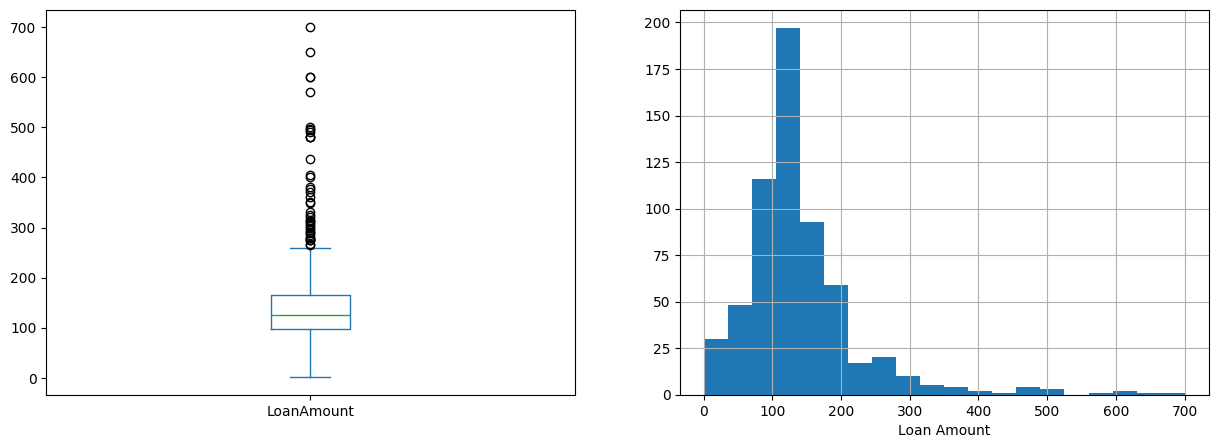

In [13]:
# Visualizing 

plt.figure(figsize=(15, 5))

plt.subplot(121)
train_df["LoanAmount"].plot(kind="box");

plt.subplot(122)
train_df["LoanAmount"].hist(bins=20);
plt.xlabel("Loan Amount")

plt.show();

**Treating Outliers using log transformation**

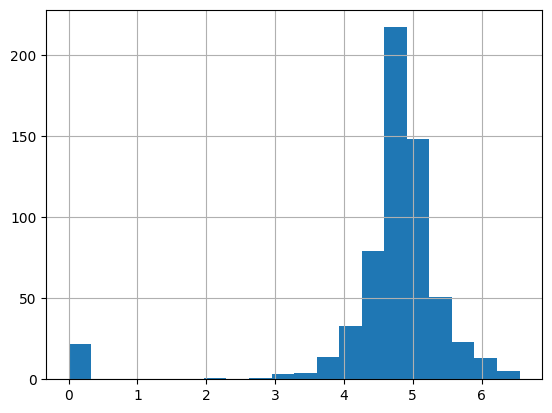

In [14]:
train_df["LoanAmount_log"] = np.log(train_df["LoanAmount"])
train_df["LoanAmount_log"].hist(bins=20);

# Treating outliers of test data set
test_df["LoanAmount_log"] = np.log(test_df["LoanAmount"])

# Training Model 1

In [15]:
train_df.drop("Loan_ID", axis=1, inplace=True)
test_df.drop("Loan_ID", axis=1, inplace=True)

**Storing target variable (feature) and dropping it as scikit learn takes target variable as a separate dataset**

In [16]:
y = train_df.Loan_Status
X = train_df.drop("Loan_Status", axis=1)

## Encoding Data

In [17]:
X = pd.get_dummies(X)
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

## Splitting data (Test Train Split)

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.3)

## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import mlflow
from mlflow.models import infer_signature

with mlflow.start_run(run_name="Logistic Regression", log_system_metrics=True):
    model = LogisticRegression()
    model.fit(x_train, y_train)

    mlflow.autolog(log_datasets=True, log_models=True)

    # Doubt
    LogisticRegression(n_jobs=1, random_state=1)

    signature = infer_signature(x_train, model.predict(x_train))
    mlflow.sklearn.log_model(model, "model", signature=signature)

2024/07/13 19:32:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/07/13 19:32:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/07/13 19:32:40 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/13 19:32:40 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [20]:
pred_test = model.predict(test_df)

In [21]:
submission = pd.read_csv("./sample_submission.csv")

In [22]:
submission["Loan_Status"] = pred_test
submission["Loan_id"] = test_cpy["Loan_ID"]

In [23]:
submission.Loan_Status.replace(0, 'N', inplace=True)
submission.Loan_Status.replace(1, 'Y', inplace=True)

In [24]:
pd.DataFrame(submission, columns = ['Loan_ID', 'Loan_Status']).to_csv('logistic.csv')

# Logistic Regression with Stratified K Folds Cross Validation

In [25]:
from sklearn.model_selection import StratifiedKFold

with mlflow.start_run(run_name="Logistic Regression Stratified K-Folds", log_system_metrics=True):
    mlflow.autolog(log_datasets=True, log_models=True)
    i=1
    kf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    for train_index, test_index in kf.split(X, y):
        print(f"{i} of kfold {kf.n_splits}", end=" ")
        xtr, xvl = X.iloc[train_index], X.iloc[test_index]
        ytr, yvl = y.iloc[train_index], y.iloc[test_index]
        model = LogisticRegression(random_state=1)
        model.fit(xtr, ytr)
        
        # Mlflow logging
        signature = infer_signature(xtr, model.predict(xtr))
        mlflow.sklearn.log_model(model, f"Logistic_Regression_model_{i}", signature=signature)
        
        pred_test = model.predict(xvl)
        score = accuracy_score(yvl, pred_test)
        print("accuracy_score ", score)
        i+=1
        pred_test = model.predict(test_df)
        pred = model.predict_proba(xvl)[:,1]

2024/07/13 19:32:40 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/07/13 19:32:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


1 of kfold 5 accuracy_score  0.7967479674796748
2 of kfold 5 accuracy_score  0.7886178861788617
3 of kfold 5 accuracy_score  0.7804878048780488
4 of kfold 5 accuracy_score  0.7723577235772358
5 of kfold 5 

2024/07/13 19:33:30 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...


accuracy_score  0.7622950819672131


2024/07/13 19:33:30 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


## ROC Curve

In [26]:
yvl.replace('N', 0, inplace=True)
yvl.replace('Y', 1, inplace=True)

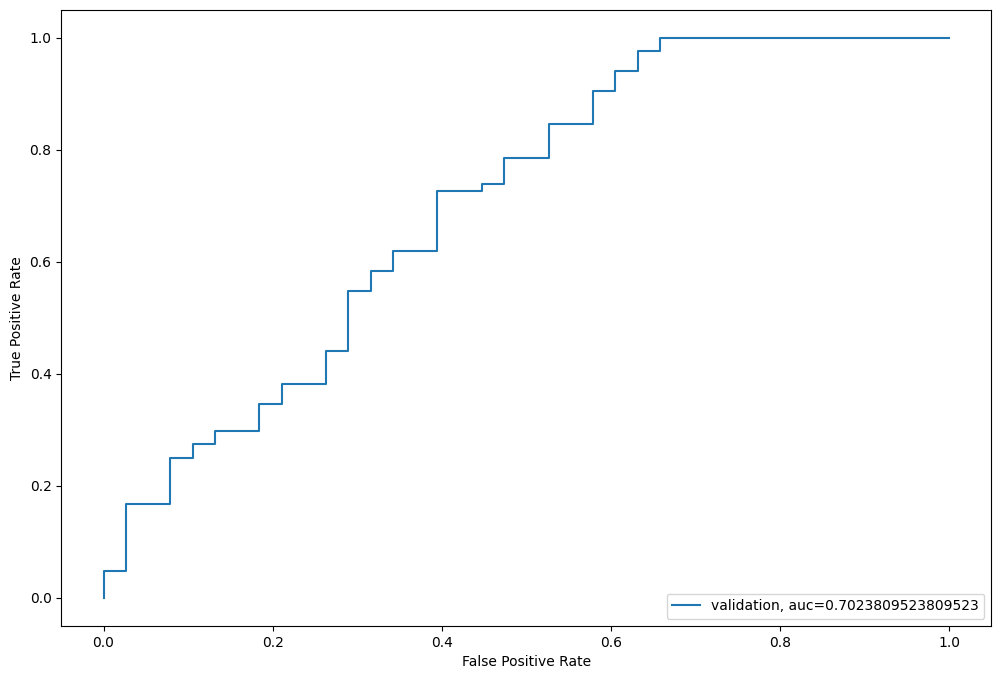

In [27]:
from sklearn import metrics 
fpr, tpr, _ = metrics.roc_curve(yvl, pred) 
auc = metrics.roc_auc_score(yvl, pred) 
plt.figure(figsize=(12,8)) 
plt.plot(fpr,tpr,label="validation, auc="+str(auc)) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4) 
plt.show()

# Feature Engineering

In [28]:
train_df['Total_Income'] = train_df['ApplicantIncome']+train_df['CoapplicantIncome']
test_df['Total_Income'] = test_df['ApplicantIncome']+test_df['CoapplicantIncome']

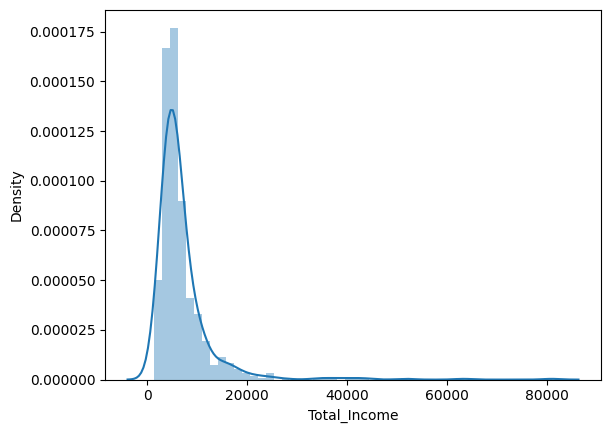

In [29]:
sns.distplot(train_df['Total_Income']);

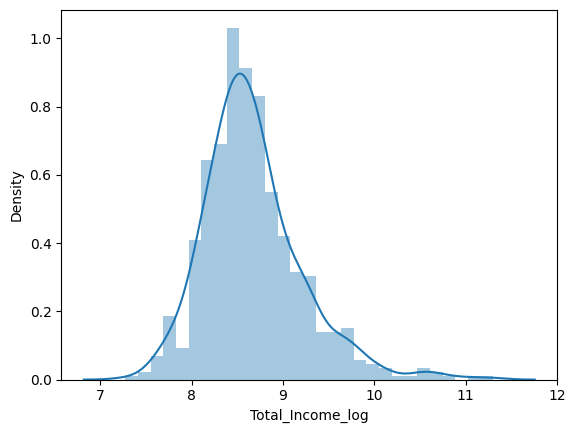

In [30]:
train_df['Total_Income_log'] = np.log(train_df['Total_Income'])
sns.distplot(train_df['Total_Income_log']);
test_df['Total_Income_log'] = np.log(test_df['Total_Income'])

In [31]:
train_df['EMI']=train_df['LoanAmount']/train_df['Loan_Amount_Term'] 
test_df['EMI']=test_df['LoanAmount']/test_df['Loan_Amount_Term']

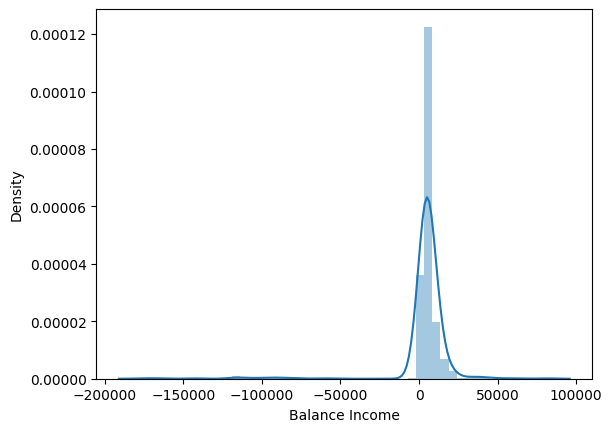

In [32]:
train_df['Balance Income']=train_df['Total_Income']-(train_df['EMI']*1000) # Multiply with 1000 to make the units equal 
test_df['Balance Income']=test_df['Total_Income']-(test_df['EMI']*1000)
sns.distplot(train_df['Balance Income']);

In [33]:
train_df=train_df.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)
test_df=test_df.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis=1)

In [34]:
train_df.columns

Index(['Credit_History', 'LoanAmount_log', 'Gender_Female', 'Gender_Male',
       'Married_No', 'Married_Yes', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Dependents_3+', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban',
       'Loan_Status_N', 'Loan_Status_Y', 'Total_Income', 'Total_Income_log',
       'EMI', 'Balance Income'],
      dtype='object')

In [35]:
train_df.Loan_Status_N

0      False
1       True
2      False
3      False
4      False
       ...  
609    False
610    False
611    False
612    False
613     True
Name: Loan_Status_N, Length: 614, dtype: bool

In [36]:
test_df.head()

,Credit_History,LoanAmount_log,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,...,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Total_Income,Total_Income_log,EMI,Balance Income
0,1.0,4.700480,False,True,False,True,True,False,False,False,...,False,True,False,False,False,True,5720,8.651724,0.305556,5414.444444
1,1.0,4.836282,False,True,False,True,False,True,False,False,...,False,True,False,False,False,True,4576,8.428581,0.350000,4226.000000
2,1.0,5.337538,False,True,False,True,False,False,True,False,...,False,True,False,False,False,True,6800,8.824678,0.577778,6222.222222
3,1.0,4.605170,False,True,False,True,False,False,True,False,...,False,True,False,False,False,True,4886,8.494129,0.277778,4608.222222
4,1.0,4.356709,False,True,True,False,True,False,False,False,...,True,True,False,False,False,True,3276,8.094378,0.216667,3059.333333


# Model Building Part II
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost

## Logistic Regression

In [37]:
X = train_df.drop(labels=['Loan_Status_N', 'Loan_Status_Y'], axis=1)
y = train_df.Loan_Status_Y

with mlflow.start_run(run_name="Logistic Regression Stratified K-Folds", log_system_metrics=True):
    mlflow.autolog(log_datasets=True, log_models=True)
    i=1
    kf1 = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
    for train_index, test_index in kf1.split(X, y):
        print(f"{i} of kfold {kf1.n_splits} ", end="")
        xtr, xvl = X.iloc[train_index], X.iloc[test_index]
        ytr, yvl = y.iloc[train_index], y.iloc[test_index]
        model1 = LogisticRegression(random_state=1)
        model1.fit(xtr, ytr)
        
        # Mlflow logging
        signature = infer_signature(xtr, model1.predict(xtr))
        mlflow.sklearn.log_model(model1, f"Logistic_Regression_model_after_Feature_Engineering_{i}", signature=signature)
        
        pred_test = model1.predict(xvl)
        score = accuracy_score(pred_test, yvl)
        print(score)
        i+=1
        pred_test = model1.predict(test_df)
        pred = model1.predict_proba(xvl)[:,1]

2024/07/13 19:33:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/07/13 19:33:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


1 of kfold 6 0.7961165048543689
2 of kfold 6 0.7766990291262136
3 of kfold 6 0.6764705882352942
4 of kfold 6 0.6764705882352942
5 of kfold 6 0.8333333333333334
6 of kfold 6 

2024/07/13 19:34:29 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...


0.6862745098039216


2024/07/13 19:34:30 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [38]:
submission['Loan_Status'] = pred_test  # filling Loan_Status with predictions
submission['Loan_ID'] = test_cpy['Loan_ID']  # filling Loan_ID with test Loan_ID

# replacing 0 and 1 with N and Y
submission['Loan_Status'].replace(0, 'N', inplace=True)
submission['Loan_Status'].replace(1, 'Y', inplace=True)

# Converting submission file to .csv format
pd.DataFrame(submission, columns=['Loan_ID', 'Loan_Status']).to_csv('Log2.csv')

## Decision Tree

In [39]:
from sklearn import tree

with mlflow.start_run(run_name="Decision Tree Classifier", log_system_metrics=True):
    mlflow.autolog(log_datasets=True, log_models=True)    
    i=1
    kf1 = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
    for train_index, test_index in kf1.split(X, y):
        print(f"{i} of kfold {kf1.n_splits} ", end="")
        xtr, xvl = X.iloc[train_index], X.iloc[test_index]
        ytr, yvl = y.iloc[train_index], y.iloc[test_index]
        model1 = tree.DecisionTreeClassifier(random_state=1)
        model1.fit(xtr, ytr)
        
        # Mlflow logging
        signature = infer_signature(xtr, model1.predict(xtr))
        mlflow.sklearn.log_model(model1, f"Decision_Tree_Classifier_model_after_Feature_Engineering_{i}", signature=signature)
        
        pred_test = model1.predict(xvl)
        score = accuracy_score(pred_test, yvl)
        print(score)
        i+=1
        pred_test = model1.predict(test_df)
        pred = model1.predict_proba(xvl)[:,1]

2024/07/13 19:34:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/07/13 19:34:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


1 of kfold 6 0.7184466019417476
2 of kfold 6 0.7669902912621359
3 of kfold 6 0.7352941176470589
4 of kfold 6 0.6568627450980392
5 of kfold 6 0.7058823529411765
6 of kfold 6 

2024/07/13 19:35:27 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/13 19:35:27 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


0.6470588235294118


In [40]:
submission['Loan_Status'] = pred_test  # filling Loan_Status with predictions
submission['Loan_ID'] = test_cpy['Loan_ID']  # filling Loan_ID with test Loan_ID

# Converting submission file to .csv format
pd.DataFrame(submission, columns=['Loan_ID', 'Loan_Status']).to_csv('Decision Tree.csv')

## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run(run_name="Random Forest Classifier", log_system_metrics=True):
    mlflow.autolog(log_datasets=True, log_models=True)
    i=1
    kf1 = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
    for train_index, test_index in kf1.split(X, y):
        print(f"{i} of kfold {kf1.n_splits} ", end="")
        xtr, xvl = X.iloc[train_index], X.iloc[test_index]
        ytr, yvl = y.iloc[train_index], y.iloc[test_index]
        model1 = RandomForestClassifier(random_state=1)
        model1.fit(xtr, ytr)
        
        # Mlflow logging
        signature = infer_signature(xtr, model1.predict(xtr))
        mlflow.sklearn.log_model(model1, f"Random_Forest_Classifier_model_after_Feature_Engineering_{i}", signature=signature)
        
        pred_test = model1.predict(xvl)
        score = accuracy_score(pred_test, yvl)
        print(score)
        i+=1

2024/07/13 19:35:27 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/07/13 19:35:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


1 of kfold 6 0.8349514563106796
2 of kfold 6 0.8640776699029126
3 of kfold 6 0.7941176470588235
4 of kfold 6 0.7058823529411765
5 of kfold 6 0.803921568627451
6 of kfold 6 

2024/07/13 19:36:29 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/13 19:36:29 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


0.7450980392156863


### Grid Search CV

In [42]:
from sklearn.model_selection import GridSearchCV

# Making changes to max_depth of the tree and number of trees (n_estimators) that will be used in Random Forest Classification
with mlflow.start_run(run_name="Random Forest Classifier with Grid Search", log_system_metrics=True):
    mlflow.autolog(log_datasets=True, log_models=True)

    paramGrid = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}

    grid_search = GridSearchCV(RandomForestClassifier(random_state=1), paramGrid)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    grid_search.fit(x_train, y_train)

    # Mlflow logging
    signature = infer_signature(x_train, grid_search.best_estimator_.predict(x_train))
    mlflow.sklearn.log_model(grid_search.best_estimator_, "Random_Forest_Classifier_model_with_Grid_Search", signature=signature)

    grid_search.best_estimator_

2024/07/13 19:36:29 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/07/13 19:36:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/07/13 19:38:23 INFO mlflow.sklearn.utils: Logging the 5 best runs, 95 runs will be omitted.
2024/07/13 19:38:28 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/07/13 19:38:28 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
